# **Chest Radiographs Basics**

In the process of taking the image, an x-ray passes through the body and reaches a detector on the other side. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb the X-rays and appear white in the image. In short -


> 
    • Black = Air
    • White = Bone
    • Grey = Tissue or Fluid

The left side of the subject is on the right side of the screen by convention. You can also see the small L at the top of the right corner. In a normal image we see the lungs as black, but they have different projections on them - mainly the rib cage bones, main airways, blood vessels and the heart.


If you are interested in the basic anatomy you can see in a chest radiograph besides the lungs you can view this [5 minutes video by QuickMedic](https://youtu.be/uo7ho8ZW2YY).

# Why to detect this
    • Pneumonia accounts for over 15% of all deaths of children under 5 years old internationally. In 2015, 920,000 children under the age of 5 died from the disease.
    • In the United States, pneumonia accounts for over 500,000 visits to emergency departments [1] and over 50,000 deaths in 2015 [2], keeping the ailment on the list of top 10 causes of death in the country.

# Symptoms to detect Pneumonia

    • The Diagnosis of pneumonia on CXR( is complicated because of a number of other conditions in the lungs such as uid overload (pulmonary edema), bleeding, volume loss (atelectasis or collapse), lung cancer, or post-radiation or surgical changes.







Characteristics | Pneumonia
--- | ---
    History | Underlying lung disease, contact with individuals having upper or lower respiratory infection, contact with birds/animals.
    Causes | Bacteria, virus, fungi; aspiration.
    Body systems | Respiratory system—lungs.
    Clinical symptoms| High fever (sometimes with chills and rigors), cough, wheezing, breathing difficulty, chest pain.
    Investigations | Blood investigations—complete blood count, ESR, sputum examination and culture, chest X-ray, CT scan, bronchoscopy, thoracocentesis, pleural fluid aspiration and culture.
    Treatments| Appropriate antimicrobial therapy, expectorant, antipyretics and analgesics, oxygen therapy (if required), fluids.


# Project Goal
    • In this competition, the primary endpoint will be the detection of bounding boxes corresponding to the diagnosis of pneumonia (e.g. lung infection) on chest radiographs, a special 2D high resolution grayscale medical image.
    • Note that pneumonia is just one of many possible disease processes that can occur on a chest radiograph, and that any given single image may contain 0, 1 or many boxes corresponding to possible pneumonia locations.


# File descriptions
    • stage_2_train.csv - the training set. Contains patientIds and bounding box / target information.
    • stage_2_detailed_class_info.csv - provides detailed information about the type of positive or negative class for each image.
    • stage_2_train_labels.csv- provides the details of the bounidng boxes of pneumonia location on lungs.

# Data fields
    • patientId _- A patientId. Each patientId corresponds to a unique image.
    • x_ - the upper-left x coordinate of the bounding box.
    • y_ - the upper-left y coordinate of the bounding box.
    • width_ - the width of the bounding box.
    • height_ - the height of the bounding box.
    • Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.


In [1]:
#@title Install required modules
! pip install pydicom

     |████████████████████████████████| 35.5MB 1.3MB/s 


In [2]:
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
import seaborn as sns
from tqdm import tqdm_notebook

from keras.models import load_model

import random
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
import cv2
from zipfile import ZipFile

import warnings
warnings.filterwarnings('ignore')
from google.colab import drive

In [3]:
#@title Import and Extract Data

tensorflow.__version__
%matplotlib inline

drive.mount('/content/drive', force_remount=False)
# One time task to extract dataset zip file 
data_folder_path = '/content/drive/My Drive/Neural Networks/'
data_path = data_folder_path + 'rsna-pneumonia-detection-challenge.zip'

#comment out if wanted to copy to grdive 
'''
!cp -r /content/stage_2_test_images /content/drive/My\ Drive/Neural\ Networks/
!cp -r /content/stage_2_train_images /content/drive/My\ Drive/Neural\ Networks/
!cd /content/drive/My\ Drive/Neural\ Networks/stage_2_test_images/;ls | wc -l
!cd /content/drive/My\ Drive/Neural\ Networks/stage_2_train_images/;ls | wc -l'''


Mounted at /content/drive


'\n!cp -r /content/stage_2_test_images /content/drive/My\\ Drive/Neural\\ Networks/\n!cp -r /content/stage_2_train_images /content/drive/My\\ Drive/Neural\\ Networks/\n!cd /content/drive/My\\ Drive/Neural\\ Networks/stage_2_test_images/;ls | wc -l\n!cd /content/drive/My\\ Drive/Neural\\ Networks/stage_2_train_images/;ls | wc -l'

In [4]:
with ZipFile(data_path, 'r') as z:
  z.extractall()
print('Extracted the pneumonia detection challenge zip file ')


Extracted the pneumonia detection challenge zip file 


In [5]:
class_details_filepath = '/content/stage_2_detailed_class_info.csv'
train_labels_filepath = '/content/stage_2_train_labels.csv'
train_data_dir = '/content/stage_2_train_images/'
test_data_dir = '/content/stage_2_test_images/'
weights_dir = '/content/drive/My Drive/weights/'

In [6]:
#@title Initialize class details CSV data and show sample data  
class_details_df = pd.read_csv(class_details_filepath)


class_details_df.sample(10)


,patientId,class
22305,c9cd4d25-9d6c-48d6-bcfe-5b1382a2065e,Lung Opacity
15678,98cd0b89-202e-4b22-83e3-ea843488ea6c,Lung Opacity
10986,734b9290-8d34-4d42-9d2b-1b3bdb98c373,Lung Opacity
18955,b15d2886-4bc4-4ed8-9be1-2d4d3a59a8c0,No Lung Opacity / Not Normal
4582,3fe6b56a-16de-450e-82b1-5257bbdbbfb0,Normal
8888,63286766-81ba-45ef-bfda-4fbd32fe90ad,Normal
24909,df976027-3267-46e9-8833-9f5f50534969,Lung Opacity
15870,9a299e91-9123-412f-b13a-1059358820eb,No Lung Opacity / Not Normal
17696,a8a32c9b-44bf-4f83-a091-2f006901ef22,Lung Opacity
1776,18a72d07-25cf-4eb4-af6a-8a81e807bae6,No Lung Opacity / Not Normal


In [7]:
#@title Initialize Label CSV data and show sample data  
labels_df = pd.read_csv(train_labels_filepath)

labels_df.sample(10)

,patientId,x,y,width,height,Target
27353,f2ed2022-f1e9-499f-b1a2-549d4090c9e4,NaN,NaN,NaN,NaN,0
1588,1748e4e2-5c73-4794-81fe-2c5fe4af8cdd,548.0,482.0,248.0,300.0,1
10688,7122e35f-0a9e-49b9-b2f3-a80e85cc521e,NaN,NaN,NaN,NaN,0
15036,9388011e-2250-40d3-be0e-39bc418d984b,622.0,583.0,204.0,412.0,1
19310,b3cf158f-1275-4a42-9073-447d96c19a21,168.0,404.0,218.0,348.0,1
18479,ae47e8ca-08cf-432e-8f3f-bbfc8413570d,156.0,184.0,160.0,173.0,1
19928,b7e6c8a5-c115-4a0a-9838-e74604a685b1,669.0,242.0,219.0,658.0,1
17735,a8e8e360-1c06-4932-820f-cc0066da187e,NaN,NaN,NaN,NaN,0
3585,394002c4-8633-4639-a5a0-6bb85e83d2ef,NaN,NaN,NaN,NaN,0
10997,7358decc-5bb3-4fad-8eab-c3c6459d2c11,616.0,195.0,226.0,393.0,1


In [8]:
#@title Code to show DICOM image for a given patient id
def show_patient_figure(patient_id, showdicomdata = False):

  fig,ax = plt.subplots(1)

  ds = pydicom.filereader.dcmread(train_data_dir + patient_id +'.dcm')
  if showdicomdata:
      print(ds)
  modality = ds.Modality
  age = ds.PatientAge
  sex = ds.PatientSex


  ax.imshow(ds.pixel_array, cmap=plt.cm.gray)
  ax.set_title('ID: {}\nModality: {} Age: {} Sex: {} '.format(
                patient_id,modality, age, sex))

  img_df = labels_df[labels_df['patientId'] == patient_id]

  for index, row in img_df.iterrows():
    x0 = row['x']
    y0 = row['y']
    width = row['width']
    height = row['height']
    rect = Rectangle((x0, y0), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

  plt.show()



In [9]:
#@title Code to Show DICOM image for a given data set
def show_figure(data, showdicomdata = False):

  fig,ax = plt.subplots(3,3, figsize=(16,18))
  img_data = list(data.T.to_dict().values())

  for i,patient in enumerate(img_data):

    patient_id = patient['patientId']
    ds = pydicom.filereader.dcmread(train_data_dir + patient_id +'.dcm')
    if showdicomdata:
      print(ds)
    modality = ds.Modality
    age = ds.PatientAge
    sex = ds.PatientSex

    ax[i//3, i%3].imshow(ds.pixel_array, cmap=plt.cm.gray)
    ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                patient['patientId'],modality, age, sex, patient['Target'], patient['class']))

    img_df = train_data_df[train_data_df['patientId'] == patient_id]

    for index, row in img_df.iterrows():
      x0 = row['x']
      y0 = row['y']
      width = row['width']
      height = row['height']
      rect = Rectangle((x0, y0), width, height, linewidth=2, edgecolor='r', facecolor='none', color="yellow",alpha = 0.1)
      ax[i//3, i%3].add_patch(rect)

  plt.show()

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.16838.1517874399.801116
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.16838.1517874399.801116
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

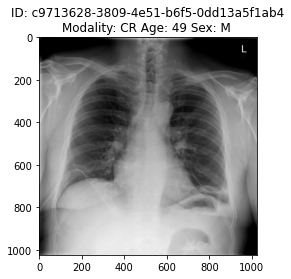

In [10]:
#@title General DICOM image and data 
show_patient_figure('c9713628-3809-4e51-b6f5-0dd13a5f1ab4', True)

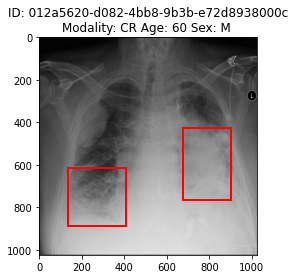

In [ ]:
#@title Class Lung Opacity 
show_patient_figure('012a5620-d082-4bb8-9b3b-e72d8938000c')


## Image analysis

From the above image , we could see that there is haziness were the labeled boxes are (termed ground glass opacity) and/or a loss of the usual boundries of the lungs (termed consolidation). They do not have clear centres and boundaries.
This patient has a "Target" value of 1 in the stage_1_train_labels.csv file.

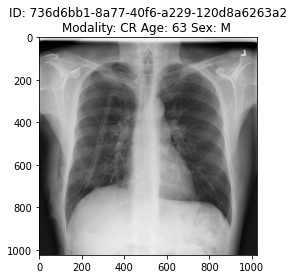

In [ ]:
#@title Class Normal
show_patient_figure('736d6bb1-8a77-40f6-a229-120d8a6263a2')

## Image analysis 

This patient is absolutely normal and in healthy condition. 
This patient woudl have 0 as "Target" value in stage_1_train_labels.csv file.

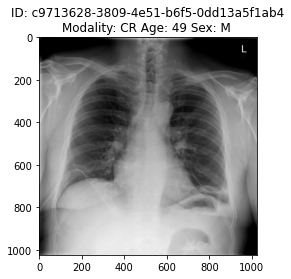

In [ ]:
#@title Class No Lung Opacity / Not Normal
show_patient_figure('c9713628-3809-4e51-b6f5-0dd13a5f1ab4')

## Image Analysis

This patient is not normal having opacities, but not with pneumonia conditions. These kind of patients would generally contians nodular opacities , whcih could or coudl not be seen with normal eye. Any ways this abnormal conditions doesn't corresponds to Pneumona and these patients were still labelled with "Target" 0 value along side with Normal category persons.

# Exploratory Data Analysis

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64


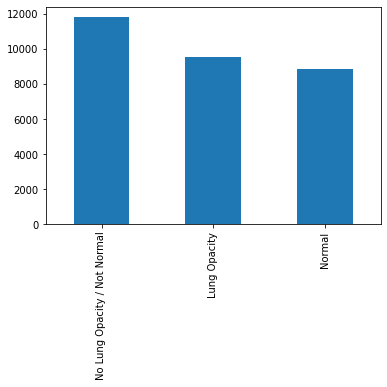

In [ ]:
#@title Classes Comparision

print(class_details_df['class'].value_counts())
class_details_df['class'].value_counts().plot.bar()

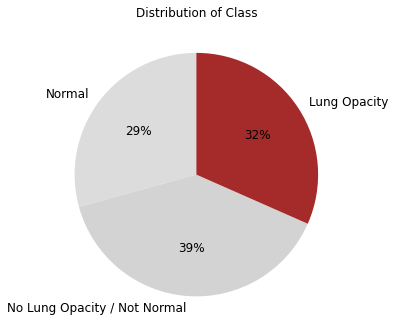

In [ ]:
#@title Distribution of `Class`
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(122)
g = (class_details_df['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))

0    20672
1     9555
Name: Target, dtype: int64

Note: Targets with 0 contains both Normal and No Lung Opacity / Not Normal category patients


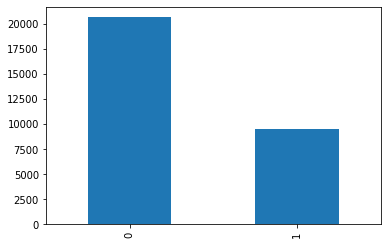

In [ ]:
#@title Target Comparision

print(labels_df['Target'].value_counts())
labels_df['Target'].value_counts().plot.bar()

print("\nNote: Targets with 0 contains both Normal and No Lung Opacity / Not Normal category patients")

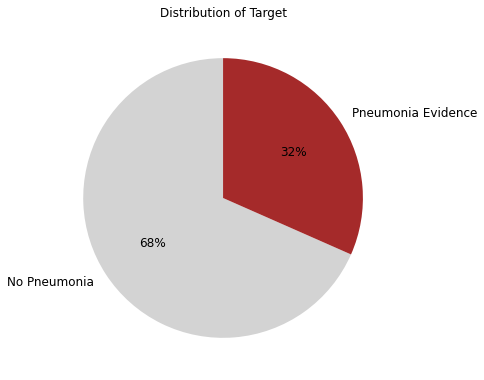

In [ ]:
#@title The distribution of `Target`

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(121)
g = (labels_df['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['No Pneumonia', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'brown'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))

plt.tight_layout()

In [10]:
#@title Combine the `Class` and `Labels` data frames and print sample data

train_data_df = pd.concat([labels_df, 
                        class_details_df.drop('patientId',1)], 1)
print('Total number of combined cases', train_data_df.shape[0], '\n')
train_data_df.sample(5)


Total number of combined cases 30227 



,patientId,x,y,width,height,Target,class
5856,4a2fec02-fe01-42cc-a1fb-a1588b147f60,633.0,243.0,248.0,458.0,1,Lung Opacity
12946,83094251-fcda-4f05-a02c-00b6fd9d764b,295.0,214.0,269.0,391.0,1,Lung Opacity
23221,d12683c4-6765-4f20-9f1c-fd6f6e98ec4b,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
20750,bd1356ed-d7fc-41d7-a11b-b1b1f2c5add1,533.0,108.0,188.0,715.0,1,Lung Opacity
2582,32c2ab07-8bea-44a6-962a-ff9064408410,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [ ]:
#@title Box count tabular data for patients 
box_df = train_data_df.groupby('patientId').size().reset_index(name='boxes')
train_data_df = pd.merge(train_data_df, box_df, on='patientId')
train_data_df.loc[train_data_df['class'] == 'No Lung Opacity / Not Normal','boxes'] = 0
train_data_df.loc[train_data_df['class'] == 'Normal','boxes'] = 0
train_data_df.groupby('boxes').size().reset_index(name='patients')


,boxes,patients
0,0,20672
1,1,2614
2,2,6532
3,3,357
4,4,52


# Analysis on boxes

1.   For the above given patient count 68% has no pneumonia and rest 32% has the pneumonia evidences
2.   A patient could have 1 or multiple pneumonia evidences which are represented in


In [ ]:
#@title Combined data sample along with box count 
train_data_df.sample(10)

,patientId,x,y,width,height,Target,class
29642,1fbb3006-6ce6-47a5-be74-9ddcaf9b3ef0,NaN,NaN,NaN,NaN,0,Normal
20896,be0d1645-263c-4dce-99e9-77f31d6ded61,193.0,192.0,238.0,639.0,1,Lung Opacity
28652,fd676e0b-14e6-40d4-8c4a-85d028559ad1,200.0,185.0,166.0,196.0,1,Lung Opacity
26998,f0310a43-5e8d-4661-9cfc-4555b47bc581,NaN,NaN,NaN,NaN,0,Normal
29371,133a1f56-1ab0-4df7-8e1b-4a6293934f3a,594.0,123.0,131.0,173.0,1,Lung Opacity
5424,46bb54fa-d083-44c4-b7af-a6015b7d90b2,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
27978,f82233c4-bf33-49d2-b1de-e7111a7428ee,NaN,NaN,NaN,NaN,0,Normal
14488,8f1ebcac-42fc-458b-9f4d-c678698c3bdc,636.0,338.0,233.0,451.0,1,Lung Opacity
3379,3802b256-c042-4f52-ab00-73877c1d1a57,NaN,NaN,NaN,NaN,0,Normal
12342,7e2a9bb1-b95a-4d72-9859-bb851216277b,NaN,NaN,NaN,NaN,0,Normal


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


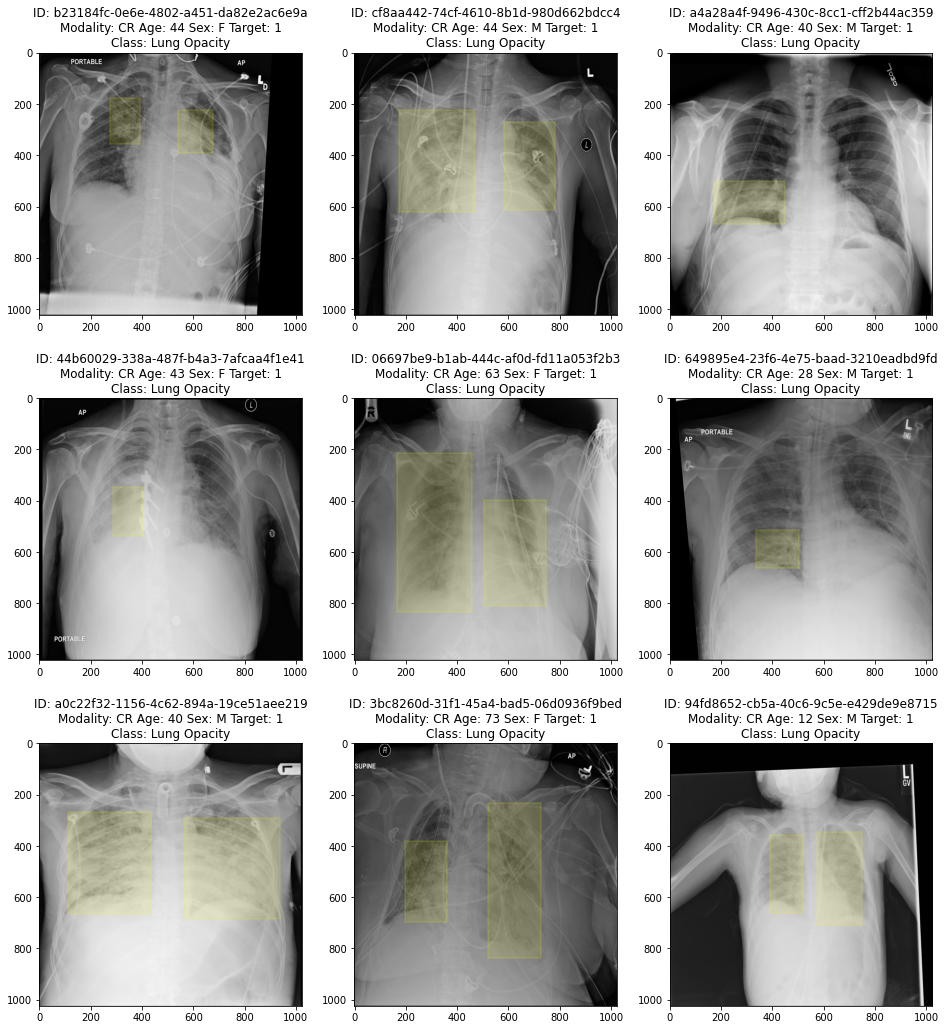

In [ ]:
#@title Batch display of Lung opacity images
sample_data = train_data_df[train_data_df['Target'] == 1].sample(9)
show_figure(sample_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


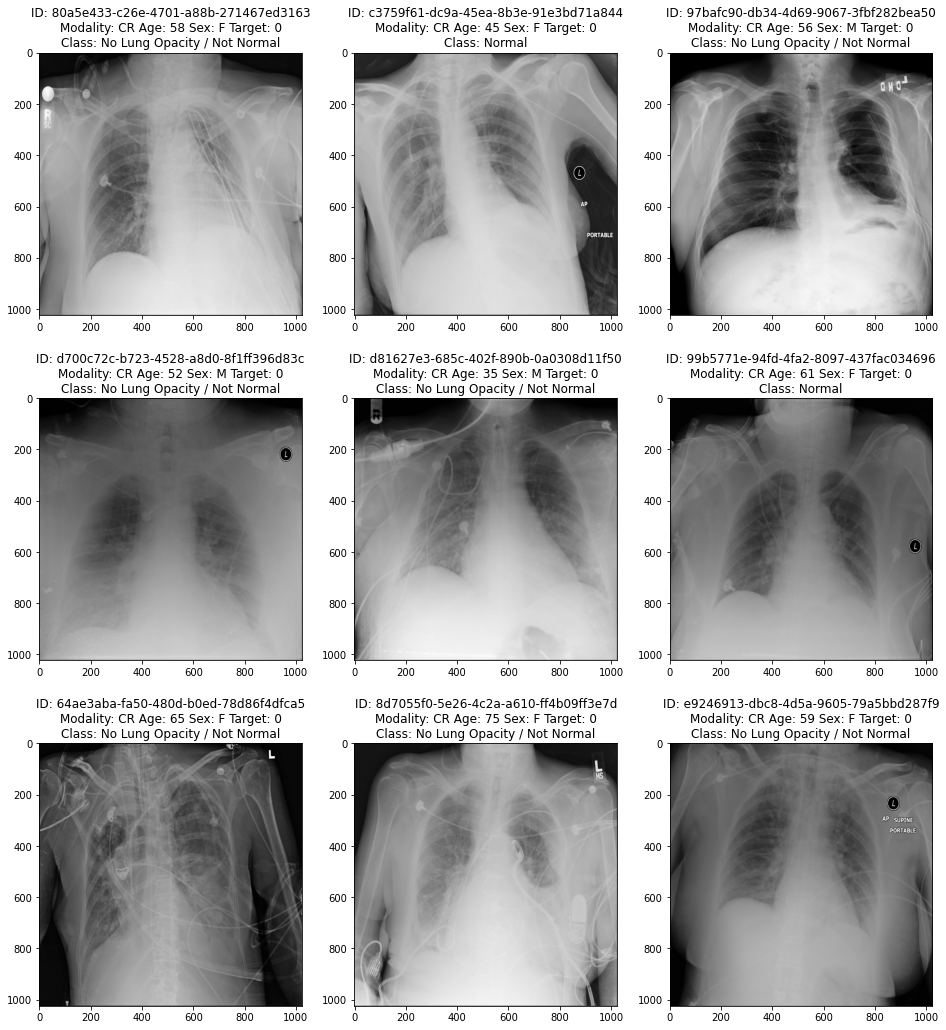

In [ ]:
#@title Batch of Non Lung opacity images
sample_data = train_data_df[train_data_df['Target'] == 0].sample(9)
show_figure(sample_data)

In [ ]:
#@title Process DICOM image data as well and use it for EDA
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing','PixelData']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(data_path)
    for i, img_name in tqdm_notebook(enumerate(image_names)):
        imagePath = os.path.join(data_path,img_name)
        data_row_img_data = pydicom.filereader.dcmread(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0])

process_dicom_data(train_data_df, train_data_dir)

ValueError: ignored

In [ ]:
#@title Sample of the extracted data
train_data_df.sample(5)

,patientId,x,y,width,height,Target,class,boxes,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,CR,51,F,CHEST,PA,WSD,1024,1024,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,CR,48,F,CHEST,PA,WSD,1024,1024,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,CR,19,M,CHEST,AP,WSD,1024,1024,0.168
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,0,CR,28,M,CHEST,PA,WSD,1024,1024,0.143
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,CR,32,F,CHEST,AP,WSD,1024,1024,0.139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,2,CR,54,M,CHEST,AP,WSD,1024,1024,0.139
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,0,CR,46,F,CHEST,PA,WSD,1024,1024,0.143
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,0,CR,45,M,CHEST,PA,WSD,1024,1024,0.168
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,2,CR,72,F,CHEST,AP,WSD,1024,1024,0.139


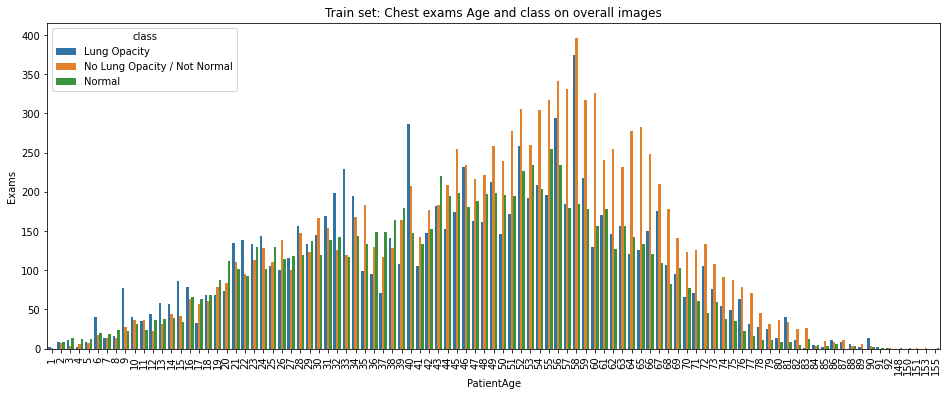

In [ ]:
#@title Chest exams analysis
tmp = train_data_df.groupby(['class', 'PatientAge'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientAge']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()


fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y = 'Exams'
            ,hue='class',data=df3)
plt.title("Train set: Chest exams Age and class on overall images")
plt.xticks(rotation=90)
plt.show()

# Analysis



1.   The data is spread from across an age of 0 - ~100, which give evidence that Pneumonia could occur at any stage of life span
2.   Considering the recroded data, the spike of the disease could be seen in late 50s
3.   There are other lung ailments which are shown under the category "No Lung Opacity/ Not Normal", which has the majority in the chart. 




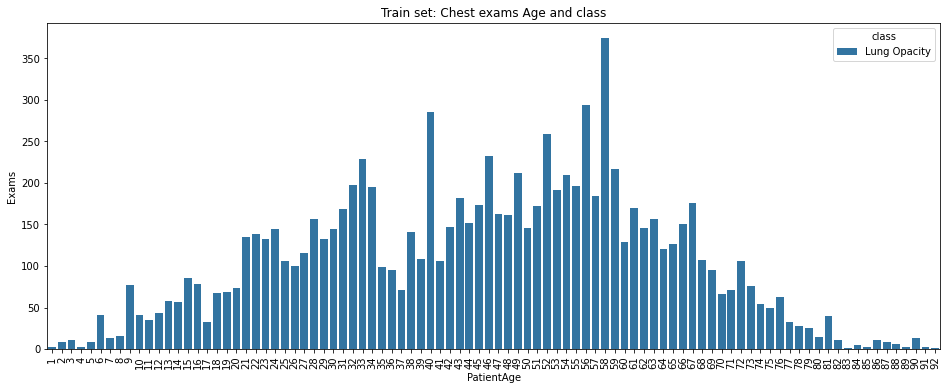

In [ ]:
#@title Chest Exam analysis - only pneumonia 
pneumonia_data_df = train_data_df[train_data_df['Target'] ==1]
tmp = pneumonia_data_df.groupby(['class', 'PatientAge'])['patientId'].count()
df1 = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
tmp = df1.groupby(['Exams','class', 'PatientAge']).count()
df3 = pd.DataFrame(data=tmp.values, index=tmp.index).reset_index()

fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.barplot(ax=ax, x = 'PatientAge', y = 'Exams'
            ,hue='class',data=df3)
plt.title("Train set: Chest exams Age and class")
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


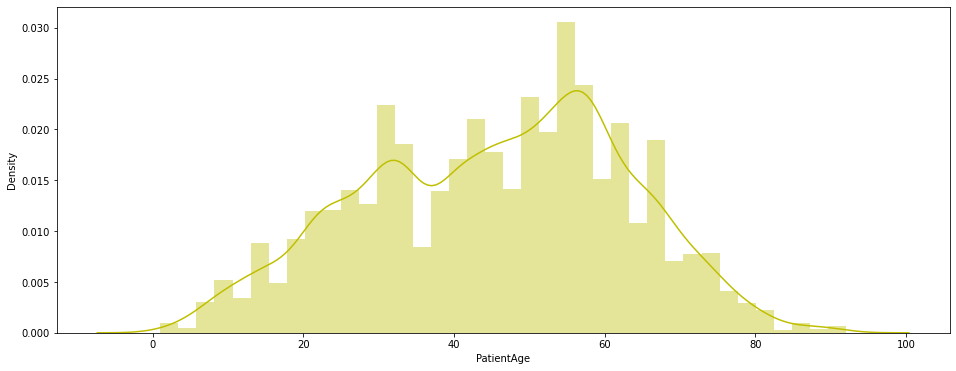

In [ ]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
ax = sns.distplot(pneumonia_data_df['PatientAge'], color="y")

# Analysis


1.   The general trneds follow similar to the over all anaysis
2.   The distribution looks binomial with disease spread slightly decreased in late 30 and spiking there after till late 50 age for the patients 



### Findings about the data 


* Training data is having a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x, y, width and height.
* There are multiple records for patients. Number of duplicates in patientID = 3,543.This indicates that each of these patients has multiple pneumonia eveidences on their lungs.
* There is also a binary target column i.e. Target indicating there was evidence of pneumonia or no definitive evidence of pneumonia.
* Class label contains: No Lung Opacity/Not Normal, Normal and Lung Opacity.
* Chest examinations with Target = 1 i.e. ones with evidence of Pneumonia are associated with Lung Opacity class.
* Chest examinations with Target = 0 i.e. those with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class.
* About 23,286 patientIds (~87% of them) provided have 1 bounding boxes while 13 patients have 4 bounding boxes!
* Multiple bounding box patients were presented in the tabular format
* DICOM images data can be extracted 
* Add features to the tabular data from the meta information in DICOM data;
* All these findings are useful as preliminary work for building a model.





# **Modelling**

In [11]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [12]:
class LungDataGenerator(keras.utils.Sequence):
    def __init__(self,directory , patientIds, batch_size=32, dim=(1024,1024), shuffle=True):
        self.patientIds = patientIds
        self.batch_size = batch_size
        self.dim=dim
        self.shuffle = shuffle
        self.directory = directory
        self.on_epoch_end()
        
    def __load__(self, patientId):
        dicom_image = pydicom.filereader.dcmread(self.directory + patientId +'.dcm').pixel_array
        # Load the dicom file as a numpy array
        

        # Create an empty mask to hold the list of bounding boxes as image segments.
        bounding_box_mask = np.zeros(dicom_image.shape) 

        # Generate the mask using the label data frame
        #targetLabelDf = trainLabelAndBoundingBoxDf.loc[patientId]
        targetLabelDf = train_data_df[train_data_df['patientId'] == patientId]

        if targetLabelDf['Target'].iloc[0] == 1:
            for index, box in targetLabelDf.iterrows():
                x_float = box['x']
                if x_float == x_float:
                  x = int(x_float)
                  y = int(box['y'])
                  width = int(box['width'])
                  height = int(box['height'])
                  bounding_box_mask[y:y+height, x:x+width] = 1

        # Resizing the image for reduction (to help build faster model).
        dicom_image = cv2.resize(dicom_image, (self.dim[0], self.dim[1]))
        bounding_box_mask = cv2.resize(bounding_box_mask, (self.dim[0], self.dim[1]))
        dicom_image = np.expand_dims(dicom_image, -1)
        bounding_box_mask = np.expand_dims(bounding_box_mask, -1)
        target = targetLabelDf['Target'].iloc[0]
        return dicom_image, bounding_box_mask, target

    def __len__(self):
        # Represents the number of batches per epoch
        return int(len(self.patientIds) / self.batch_size)
    
    def __getitem__(self, index):
        # Generates the indexes associated with one batch
        targetPatientIds = self.patientIds[index * self.batch_size : (index + 1) * self.batch_size]
        
        items = [self.__load__(id) for id in targetPatientIds]

        # Zip the images and masks for the target patients.
        imgs, masks, targets = zip(*items)

        # Create numpy batch
        imgs = np.array(imgs)
        masks = np.array(masks)
        targets = np.array(targets)
        return imgs, masks, targets
        
    def on_epoch_end(self):
        # Shuffles the data after every epoch
        if self.shuffle:
            np.random.shuffle(self.patientIds)


In [13]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

print('Combine BCE and IOU loss')
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

print('Get mean IOU as a metric')
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis = [1, 2, 3])
    union = tf.reduce_sum(y_true, axis = [1, 2, 3]) + tf.reduce_sum(y_pred, axis = [1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

Combine BCE and IOU loss
Get mean IOU as a metric


In [14]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # Input
    inputs = keras.Input(shape=(input_size, input_size, 1))

    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # Residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
        
    # Output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
epoch_count = 5

# Define cosine annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = epoch_count
    return lr * (np.cos(np.pi * x / epochs) + 1.) / 2

In [16]:
training_data_percent = 0.7

patient_unique_df = train_data_df['patientId'].unique()
training_data_end_index = int(patient_unique_df.shape[0] * training_data_percent)
training_patientIds_box = patient_unique_df[0:training_data_end_index]
validation_patientIds_box = patient_unique_df[training_data_end_index:]


params = {'dim': (256, 256), 'batch_size': 32, 'shuffle': True}
training_data_generator_box = LungDataGenerator(train_data_dir, training_patientIds_box, **params)
validation_data_generator_box = LungDataGenerator(train_data_dir, validation_patientIds_box, **params)

In [17]:
from keras.callbacks import ModelCheckpoint


time_callback = TimeHistory()

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
ckpt_callback = ModelCheckpoint(filepath=weights_dir + 'weights.{epoch:02d}-{accuracy:.2f}.hdf5', monitor='val_loss')
callbacks = [ckpt_callback, learning_rate, time_callback]


In [ ]:
# For training, only execute if wanted to train the model again 

# Load checkpoint:
checkpoint_path = '/content/drive/My Drive/weights/weights.03-0.96.hdf5'
if checkpoint_path is not None:
    print('Resuming the model training using the given weights')
    # Load model:
    #model = load_model(checkpoint_path)
    # Finding the epoch index from which we are resuming
    model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
    model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])
    model.load_weights(checkpoint_path)
    initial_epoch = 3
else:
    model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
    model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])
    model.summary()
    initial_epoch = 0

history = model.fit(training_data_generator_box, validation_data=validation_data_generator_box, callbacks=callbacks, epochs=epoch_count,initial_epoch=initial_epoch, workers=4, use_multiprocessing=True)

Trainign continuation
Epoch 4/5
583/583 [==============================] - 30940s 53s/step - loss: 0.1169 - accuracy: 0.9622 - mean_iou: 0.6175 - val_loss: 0.0844 - val_accuracy: 0.9630 - val_mean_iou: 0.5793
Epoch 5/5
 25/583 [>.............................] - ETA: 7:11:58 - loss: 0.1092 - accuracy: 0.9641 - mean_iou: 0.5889

Process Keras_worker_ForkPoolWorker-17:
Process Keras_worker_ForkPoolWorker-19:
Process Keras_worker_ForkPoolWorker-18:
Process Keras_worker_ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File

In [18]:
#For testing, creating the model from the check point 

model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])

checkpoint_path = '/content/drive/My Drive/weights/weights.04-0.96.hdf5'

model.load_weights(checkpoint_path)


n test samples: 3000


We can now analyze the predictions on the validation data.


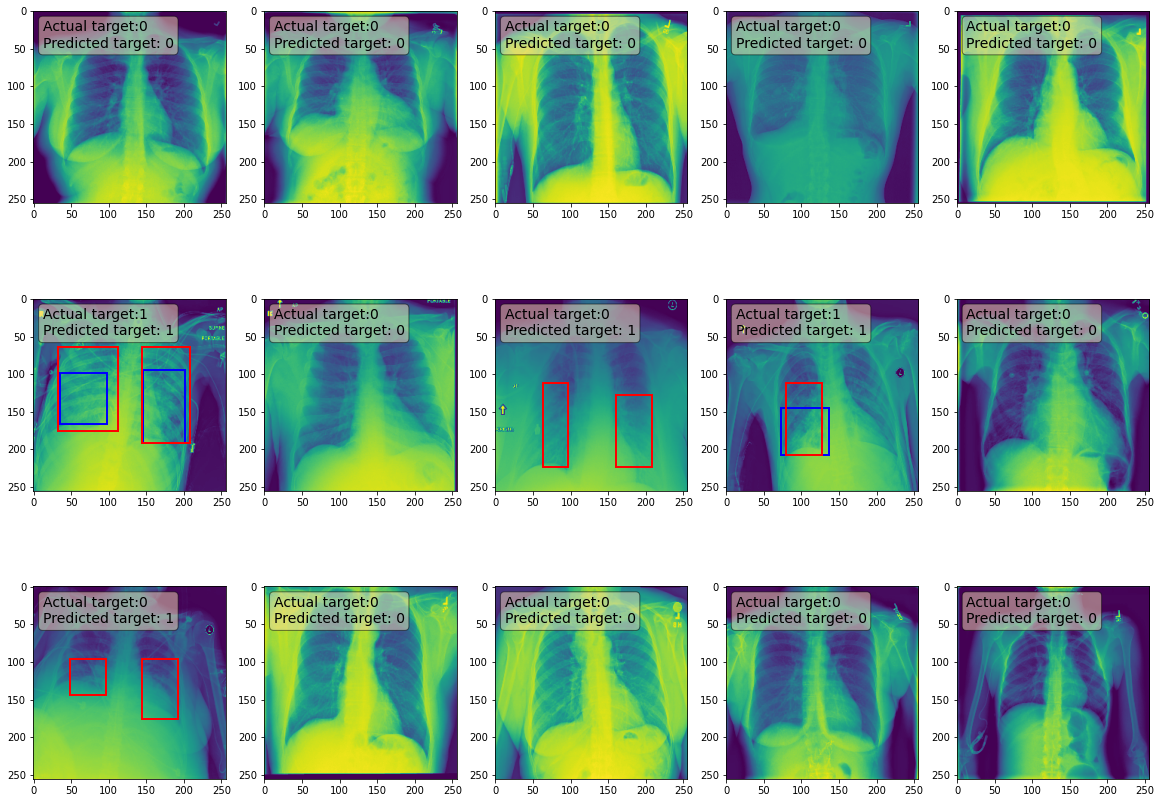

In [24]:
print('We can now analyze the predictions on the validation data.')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

for imgs, masks, targets in validation_data_generator_box:
    # Predict a batch of images
    predictions = model.predict(imgs)
    # Create a plot for the images
    fig, axes = plt.subplots(3, 5, figsize=(20, 15))
    axes = axes.ravel()
    axidx = 0
    for img, mask, prediction, target in zip(imgs, masks, predictions, targets):
      axes[axidx].imshow(img[:,:,0])      
        # Apply threshold to true mask
      comp = mask[:,:,0] > 0.5
        
        # Apply connected components.
      comp = measure.label(comp)
        
        # Apply bounding boxes
      for region in measure.regionprops(comp):
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(Rectangle((x1, y1), width, height, linewidth=2, edgecolor='b', facecolor='none'))
            
        # Apply threshold to the predicted mask
      comp = prediction[:,:,0] > 0.5
        
        # Apply connected components.
      comp = measure.label(comp)
        
      predTarget = 0
        
        # Apply bounding boxes
      for region in measure.regionprops(comp):
            # If a region is found mark the target value as 1
            predTarget = 1
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            axes[axidx].add_patch(Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))
        
      axes[axidx].text(0.05, 0.95, f'Actual target:{target}  \nPredicted target: {predTarget}', transform=axes[axidx].transAxes, fontsize=14, verticalalignment='top', bbox=props)
      axidx += 1
      if(axidx >= 15):
          break;
        
    plt.show()
    
    # Display only one plot per batch
    break

In [58]:
class LungTestDataGenerator(keras.utils.Sequence):
    def __init__(self,directory , patientIds, batch_size=32, dim=(1024,1024), shuffle=True):
        self.patientIds = patientIds
        self.batch_size = batch_size
        self.dim=dim
        self.shuffle = shuffle
        self.directory = directory
        self.on_epoch_end()
        
    def __load__(self, patientId):
        dicom_image = pydicom.filereader.dcmread(self.directory + patientId + '.dcm').pixel_array
        # Resizing the image for reduction (to help build faster model).
        dicom_image = cv2.resize(dicom_image, (self.dim[0], self.dim[1]))
        dicom_image = np.expand_dims(dicom_image, -1)
        return dicom_image

    def __len__(self):
        # Represents the number of batches per epoch
        return int(len(self.patientIds) / self.batch_size)
    
    def __getitem__(self, index):
        # Generates the indexes associated with one batch
        targetPatientIds = self.patientIds[index * self.batch_size : (index + 1) * self.batch_size]
        items = [self.__load__(id) for id in targetPatientIds]
        #imgs = zip(*items)
        imgs = np.array(items)
        return imgs
        
    def on_epoch_end(self):
        # Shuffles the data after every epoch
        if self.shuffle:
            np.random.shuffle(self.patientIds)


In [66]:
def predict(patientIds):
  print('n test samples:', len(patientIds))

# create test generator with predict flag set to True
  params = {'dim': (256, 256), 'batch_size': 1, 'shuffle': True}
  test_data_generator_box = LungTestDataGenerator(train_data_dir, patientIds, **params)
 
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

  for imgs in test_data_generator_box:
    # Predict a batch of images
    predictions = model.predict(imgs)

    # Create a plot for the images
    fig,ax = plt.subplots(1)

    for img, prediction in zip(imgs, predictions):
      ax.imshow(img[:,:,0], cmap=plt.cm.gray)
              # Apply threshold to the predicted mask
      comp = prediction[:,:,0] > 0.5
        
        # Apply connected components.
      comp = measure.label(comp)

      predictedTarget = 0 
        # Apply bounding boxes
      for region in measure.regionprops(comp):
            predictedTarget = 1
            # If a region is found mark the target value as 1
            predTarget = 1
            y1, x1, y2, x2 = region.bbox
            height = y2-y1
            width = x2-x1
            ax.add_patch(Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none'))
      ax.text(0.05, 0.95, f'Predicted target: {predictedTarget}', transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props) 
    plt.show()



n test samples: 1


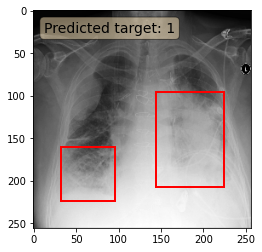

In [67]:
predict(['012a5620-d082-4bb8-9b3b-e72d8938000c'])